In [1]:
!pip install matplotlib opencv-python diffusers transformers scipy accelerate

     |████████████████████████████████| 11.2 MB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 61.8 MB 269 kB/s eta 0:00:01    |████                            | 7.8 MB 6.3 MB/s eta 0:00:09     |█████████▊                      | 18.7 MB 7.0 MB/s eta 0:00:07     |████████████████████▍           | 39.4 MB 9.2 MB/s eta 0:00:03     |█████████████████████████▍      | 49.1 MB 7.0 MB/s eta 0:00:02     |████████████████████████████▊   | 55.6 MB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 604 kB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 199 kB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 757 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 190 kB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 7.6 MB 6

In [76]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from tira_utils import get_input_directory_and_output_directory, normalize_run
import pyterrier as pt
import pandas as pd
import os
import json
from tqdm import tqdm
from glob import glob
from pathlib import Path
from collections import Counter
import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from PIL import Image
from transformers import pipeline

In [3]:
from preselection import retrieve

I will use a small hardcoded example located in /workspace/dataset22/.
The output directory is /tmp/


6749it [04:29, 32.34it/s]

15:44:49.496 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (I47e296f116f4c218) - further warnings are suppressed


23841it [14:18, 27.78it/s]


15:55:01.228 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 2 empty documents


In [4]:
def load_queries():
    file_name = 'dataset22/topics.xml'
    
    if not os.path.exists(file_name):
        raise ValueError(f'Could not find the file "{file_name}". Got: {glob(input_directory + "/*")}')
    
    topics = pd.read_xml(file_name)
    
    ret = pd.DataFrame()
    # https://github.com/terrier-org/pyterrier/issues/62\n",
    ret['query'] = topics['title'].apply(lambda i: "".join([x if x.isalnum() else " " for x in i]))
    ret['qid'] = topics['number']
    return ret

In [77]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")
#https://huggingface.co/facebook/bart-large-mnli

input_directory = '/workspace/dataset22/'

In [78]:
# load image text
# We use some very baseline method to get a textual representation: we just use the text of the pages that contain the image.
def load_image_text(image_id):
    ret = ''
    for txt_file in glob(input_directory +'/images/' + image_id[:3] + '/' + image_id + '/*/*/*/text.txt'):
        ret += '\n\n' + open(txt_file).read()
    return ret.strip()

def load_queries():
    file_name = input_directory + 'topics-task3.xml'
    
    if not os.path.exists(file_name):
        raise ValueError(f'Could not find the file "{file_name}". Got: {glob(input_directory + "/*")}')
    
    topics = pd.read_xml(file_name)
    
    ret = pd.DataFrame()
    # https://github.com/terrier-org/pyterrier/issues/62\n",
    ret['query'] = topics['title'].apply(lambda i: "".join([x if x.isalnum() else " " for x in i]))
    ret['qid'] = topics['number']
    return ret


def determine_stance(text, query):
    labels = ["contra "+ query, "pro "+ query, "neutral "+ query]
    result = classifier(text, labels)
    # sorts the labels starting with the most likely
    if result["labels"][0].startswith("contra"):
        return "contra", result["scores"][0]
    elif result["labels"][0].startswith("pro"):
        return "pro", result["scores"][0]
    else: 
        return "neutral", result["scores"][0]
    

def detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_ids, query, x):
    # get image ids from preranking
    # get image texts based on preranking 
    pro_imgs = {}
    contra_imgs = {}
    for image_id in image_ids:
        text = load_image_text(image_id)
        # deploy model
        stance, score = determine_stance(text, query)
        print(image_id, stance, score)
        # separate pro and con texts; sort out neutral texts
        if stance == "pro":
            pro_imgs[image_id] = score
        elif stance == "contra": 
            contra_imgs[image_id] = score
        # sort according to scores
        sorted_pro = dict(sorted(pro_imgs.items(), key=lambda x:x[1], reverse=True))
        sorted_contra = dict(sorted(contra_imgs.items(), key=lambda x:x[1], reverse=True))
        # return best x results for each side
        pro_ids = []
        contra_ids = []
        i = 0
        for key in sorted_pro:
            if i < len(sorted_pro.keys()) and i < x:
                pro_ids.append(key)
            else: 
                break
            i += 1
        i = 0
        for key in sorted_contra:
            if i < len(sorted_contra.keys()) and i < x:
                contra_ids.append(key)
            else: 
                break
            i += 1
    return pro_ids, contra_ids
# not sorted right

In [5]:
def load_image_paths(image_ids):
    image_paths = []
    
    for image_id in image_ids:
        image_paths.append('dataset22/images/' + image_id[:3] + '/' + image_id + '/image.webp')
        
    return image_paths

In [30]:
def load_image_generator():
    with open('token.txt') as ifp:
        access_token = ifp.readline()
        # print('Read a token of length {}'.format( len(access_token) ))
    
    model_id = "CompVis/stable-diffusion-v1-4"
    device = "cuda"
    
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16", use_auth_token=access_token, device_map="auto", cache_dir="stable_diffusion_cache")
    pipe = pipe.to(device)
    
    return pipe
    
def generate_image(pipe, prompt, image_name, isrealistic, guidance_scale=20, inference_steps=50):
    if isrealistic:
        final_prompt = "a photograph about the topic: " + prompt
    else:
        final_prompt = "an image in comic style about the topic: " + prompt
    
    print(final_prompt)
    
    image = None
    
    while image == None or not image.getbbox():
        image = pipe(final_prompt, guidance_scale=guidance_scale, num_inference_steps=inference_steps).images[0]
        print(not image.getbbox())

    image.save("image_results/" + image_name + ".png")
    
def show_image(image_name):
    image = Image.open("image_results/" + image_name + ".png")
    image.show()

In [8]:
def flann_index_kdtree_matcher(image1, image2):
    MIN_MATCH_COUNT = 10
    
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    
    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1_gray, None)
    kp2, des2 = sift.detectAndCompute(image2_gray, None)
    
    if des1 is None or des2 is None:
        return [], 0
            
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    global good
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    
    if len(good) == 0:
        return [], 0
    
    most_common_keypoint_matches = Counter(x.trainIdx for x in good).most_common(1)[0]
    
    # single keypoint check for to many matches
    if most_common_keypoint_matches[1] > 10:
        return [], 0
            
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        
        if M is None:
            print("empty Homography on image")
            return [], 0
        
        matchesMask = mask.ravel().tolist()
        
        h,w, _ = image1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
        image2 = cv.polylines(image2,[np.int32(dst)],True,255,3, cv.LINE_AA)
             
    else:
        # print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=cv.DrawMatchesFlags_DEFAULT)
    
    img_matches = np.empty((max(image1.shape[0], image2.shape[0]), image1.shape[1]+image2.shape[1], 3), dtype=np.uint8)
    # img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, **draw_params)
    
    # plt.imshow(img3, ), plt.show()
    
    return img3, len(good)

In [36]:
def sort_images(images, dataframe):
    sorted_images = []
    
    for i in range(len(images)):
        image_id = dataframe["image_id"][i]
        sorted_images.append(images[image_id])
    
    return sorted_images

def rank_images(images, image_name):
    print("image_results/" + image_name)
    topic_img = cv.cvtColor(cv.imread("image_results/" + image_name), cv.COLOR_BGR2RGB)
    image_ids = []
    match_numbers = []
    img_num = 0

    for image in images:
        # print(img_num)
    
        if image.size <= 100000000:
            img, good_matches = flann_index_kdtree_matcher(topic_img, image.copy())
        
            image_ids.append(img_num)
            match_numbers.append(good_matches)
    
        img_num += 1

    image_id_and_match_num_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
    sorted_image_id_and_match_num_dataframe = image_id_and_match_num_dataframe.sort_values(by=['match_num'], ascending=False).reset_index(drop=True)
    
    return sort_images(images, sorted_image_id_and_match_num_dataframee), sorted_image_id_and_match_num_dataframe

In [10]:
def show_multiple_images(image_list, row_count, col_count, save_image_name=""):
    for i in range(0, len(image_list), row_count*col_count):
        fig = plt.figure(figsize=(20, 120), dpi=80)
    
    for j in range(0, row_count*col_count):
        fig.add_subplot(row_count, col_count, j+1)
        plt.imshow(image_list[i+j])
        
    if save_image_name != "":
        save_path = "image_results/" + save_image_name
        plt.savefig(save_path)
        
    plt.show()

In [73]:
def createSubmissionFormat(preselection_data, ranked_image_id_dataframe, image_num=10):
    submission_format = ""
    rank = 1
    
    for i in range(image_num):
        local_image_id = ranked_image_id_dataframe["image_id"][i]
        
        image_data = preselection_data.iloc[local_image_id]
        query_id = image_data.loc["qid"]
        stance = "-"
        image_id = image_data.loc["docno"]
        image_rank = rank
        image_score = 50 - (rank-1)
        method = "-"
        
        submission_format += (str(query_id) + " " + str(stance) + " " + str(image_id) + " " + str(image_rank) + " " + str(image_score) + " " + str(method) + "\n")
        
        rank += 1
        
    print(submission_format)

In [11]:
queries = load_queries()

queries.iloc[[1]]["query"].values[0]

'Is vaping with e cigarettes safe '

In [16]:
pipe = load_image_generator()

Fetching 16 files: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 844.09it/s]
/opt/conda/lib/python3.7/site-packages/transformers/models/clip/feature_extraction_clip.py:31: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  FutureWarning,


an image in comic style about the topic: Is vaping with e cigarettes safe 


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


True


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


True


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


True


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


True


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


False


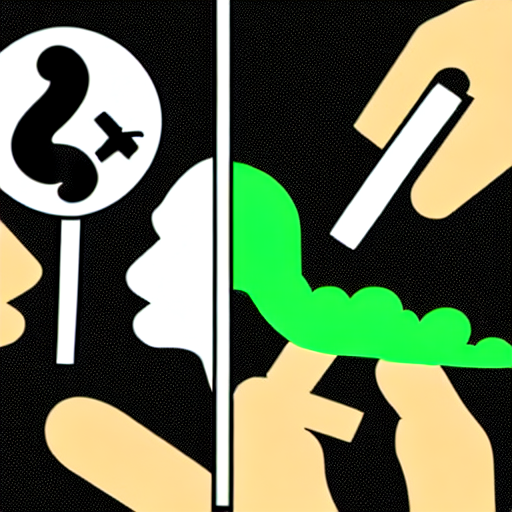

In [32]:
# "teachers_tenure"
# "vaping_cigarette"
generate_image(pipe, queries.iloc[[1]]["query"].values[0], "vaping_cigarette2", False)

show_image("vaping_cigarette2")

In [74]:
queries = load_queries()

preselection_data = retrieve(queries.iloc[[1]])

image_paths = load_image_paths(preselection_data["docno"])
images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]

ranked_images, sorted_image_id_and_match_num_dataframe = rank_images(images, "vaping_cigarette2.png")
# show_multiple_images(ranked_images, 25, 2, "vaping_cigarette2_plot.png")
createSubmissionFormat(preselection_data, sorted_image_id_and_match_num_dataframe)

BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.44q/s]


image_results/vaping_cigarette2.png
2 - I57b3d99281c71a10 1 50 -
2 - Iba4f71975297476e 2 49 -
2 - I10d92635503b5582 3 48 -
2 - I2fed43b070c21bfa 4 47 -
2 - I94e0d91acb407990 5 46 -
2 - I4c1dd664acef7f44 6 45 -
2 - Ib7947dcd9a7c462d 7 44 -
2 - Ib2c49cc10a21fd60 8 43 -
2 - I8e58116cb8e33efa 9 42 -
2 - Ia640a01ea49643d0 10 41 -

